# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

Goal is to beat the original Food101 paper with 10% of the training (leveraging the power of depp learning).

Our baseline to beat is 50.76% accuracy across 101 classes.

## Creating helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-13 14:45:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-13 14:45:27 (94.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Goal is to beat the original Food101 paper with 10% of the training data.

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2023-02-13 14:45:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  16.5MB/s    in 89s     

2023-02-13 14:47:00 (17.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/poutine'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Resacaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [9]:
from tensorflow.python import train
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happends during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 3s 0us/step


In [10]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5


237/237 [==============================] - 129s 477ms/step - loss: 3.3837 - accuracy: 0.2725 - val_loss: 2.4705 - val_accuracy: 0.4632
Epoch 2/5
237/237 [==============================] - 96s 404ms/step - loss: 2.1956 - accuracy: 0.5018 - val_loss: 2.0425 - val_accuracy: 0.5109
Epoch 3/5
237/237 [==============================] - 92s 385ms/step - loss: 1.8213 - accuracy: 0.5670 - val_loss: 1.8725 - val_accuracy: 0.5254
Epoch 4/5
237/237 [==============================] - 100s 418ms/step - loss: 1.6097 - accuracy: 0.6124 - val_loss: 1.7887 - val_accuracy: 0.5373
Epoch 5/5
237/237 [==============================] - 97s 408ms/step - loss: 1.4481 - accuracy: 0.6483 - val_loss: 1.7361 - val_accuracy: 0.5479


In [12]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 71s 90ms/step - loss: 1.5866 - accuracy: 0.5822


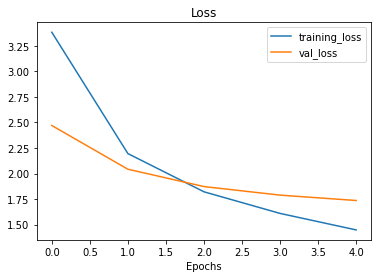

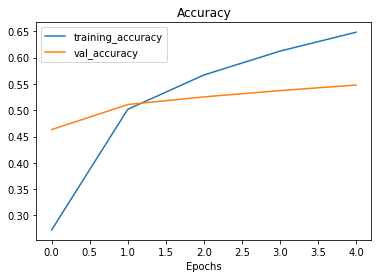

In [13]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [16]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [17]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [18]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10


237/237 [==============================] - 109s 396ms/step - loss: 1.4908 - accuracy: 0.5999 - val_loss: 1.6184 - val_accuracy: 0.5739
Epoch 6/10
237/237 [==============================] - 90s 380ms/step - loss: 1.0726 - accuracy: 0.7042 - val_loss: 1.7089 - val_accuracy: 0.5617
Epoch 7/10
237/237 [==============================] - 90s 379ms/step - loss: 0.8328 - accuracy: 0.7682 - val_loss: 2.0180 - val_accuracy: 0.5117
Epoch 8/10
237/237 [==============================] - 89s 373ms/step - loss: 0.6225 - accuracy: 0.8219 - val_loss: 2.0485 - val_accuracy: 0.5342
Epoch 9/10
237/237 [==============================] - 97s 407ms/step - loss: 0.5065 - accuracy: 0.8543 - val_loss: 2.0808 - val_accuracy: 0.5241
Epoch 10/10
237/237 [==============================] - 85s 358ms/step - loss: 0.4317 - accuracy: 0.8726 - val_loss: 2.2398 - val_accuracy: 0.4992


In [19]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 72s 91ms/step - loss: 1.9271 - accuracy: 0.5662


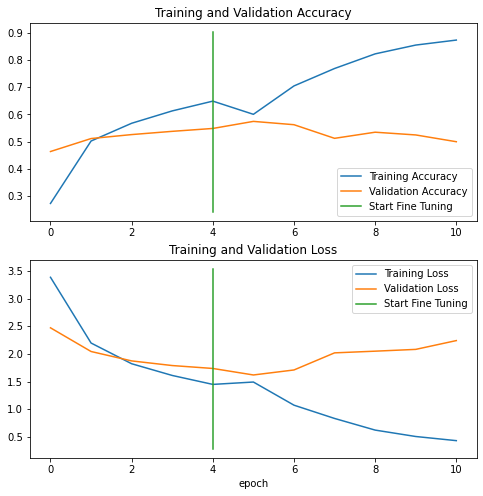

In [20]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong. 

In [23]:
import tensorflow as tf

# Download preptrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-02-13 15:16:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  12.7MB/s    in 3.9s    

2023-02-13 15:16:16 (11.5 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [24]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [25]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [26]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 77s 94ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [27]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbose to see how long is left

790/790 [==============================] - 75s 93ms/step


In [28]:
len(test_data)

790

In [29]:
# How many predictions are there?
len(preds_probs)

25250

In [30]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [31]:
# Let's see what first 10 predictions look like
preds_probs[:10]

array([[5.9542067e-02, 3.5742048e-06, 4.1376896e-02, ..., 1.4138652e-09,
        8.3530831e-05, 3.0897569e-03],
       [9.6401680e-01, 1.3753220e-09, 8.4780413e-04, ..., 5.4287149e-05,
        7.8362204e-12, 9.8465835e-10],
       [9.5925879e-01, 3.2533680e-05, 1.4866935e-03, ..., 7.1891486e-07,
        5.4397424e-07, 4.0276045e-05],
       ...,
       [4.7313309e-01, 1.2931172e-07, 1.4805557e-03, ..., 5.9750077e-04,
        6.6968969e-05, 2.3469342e-05],
       [4.4571940e-02, 4.7265320e-07, 1.2258494e-01, ..., 6.3498710e-06,
        7.5318612e-06, 3.6778918e-03],
       [7.2438931e-01, 1.9249691e-09, 5.2310974e-05, ..., 1.2291421e-03,
        1.5792678e-09, 9.6395437e-05]], dtype=float32)

In [32]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.95420673e-02, 3.57420481e-06, 4.13768962e-02, 1.06605957e-09,
        8.16142798e-09, 8.66396554e-09, 8.09271967e-07, 8.56525787e-07,
        1.98591097e-05, 8.09776793e-07, 3.17277427e-09, 9.86735472e-07,
        2.85322982e-04, 7.80488951e-10, 7.42300879e-04, 3.89163033e-05,
        6.47404886e-06, 2.49773507e-06, 3.78912046e-05, 2.06783270e-07,
        1.55384078e-05, 8.15071758e-07, 2.62305684e-06, 2.00106854e-07,
        8.38276890e-07, 5.42159296e-06, 3.73909620e-06, 1.31505322e-08,
        2.77615618e-03, 2.80519707e-05, 6.85622836e-10, 2.55749037e-05,
        1.66889440e-04, 7.64072861e-10, 4.04528371e-04, 1.31506841e-08,
        1.79573601e-06, 1.44482851e-06, 2.30628774e-02, 8.24670053e-07,
        8.53658491e-07, 1.71386273e-06, 7.05254342e-06, 1.84020976e-08,
        2.85534270e-07, 7.94834523e-06, 2.06815321e-06, 1.85251878e-07,
        3.36196422e-08, 3.15225829e-04, 1.04109422e-05, 8.54484426e-07,
        8.47418606e-01, 1.05554454e-05, 4.40947048e-07, 3.740425

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [33]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95420673e-02 3.57420481e-06 4.13768962e-02 1.06605957e-09
 8.16142798e-09 8.66396554e-09 8.09271967e-07 8.56525787e-07
 1.98591097e-05 8.09776793e-07 3.17277427e-09 9.86735472e-07
 2.85322982e-04 7.80488951e-10 7.42300879e-04 3.89163033e-05
 6.47404886e-06 2.49773507e-06 3.78912046e-05 2.06783270e-07
 1.55384078e-05 8.15071758e-07 2.62305684e-06 2.00106854e-07
 8.38276890e-07 5.42159296e-06 3.73909620e-06 1.31505322e-08
 2.77615618e-03 2.80519707e-05 6.85622836e-10 2.55749037e-05
 1.66889440e-04 7.64072861e-10 4.04528371e-04 1.31506841e-08
 1.79573601e-06 1.44482851e-06 2.30628774e-02 8.24670053e-07
 8.53658491e-07 1.71386273e-06 7.05254342e-06 1.84020976e-08
 2.85534270e-07 7.94834523e-06 2.06815321e-06 1.85251878e-07
 3.36196422e-08 3.15225829e-04 1.04109422e-05 8.54484426e-07
 8.47418606e-01 1.05554454e-05 4.40947048e-07 3.74042502e-05
 3.53062278e-05 3.24890061e-05 6.73147370e-

In [34]:
# Get the pred clases of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [35]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all our model's predictions, to evaluate them, we need to compare them to original test dataset labels.

In [37]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [38]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for iamges, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]